In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


     |████████████████████████████████| 3.1MB 5.8MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


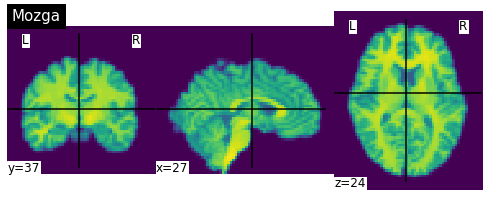

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from tqdm.notebook import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt

!pip install nilearn
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting

labels = np.load("MyDrive/labels.npy")
tensors = np.load("MyDrive/tensors.npy")

affine = np.diag([1, 1, 1, 1])
t = nib.Nifti1Image(tensors[0], affine)
plotting.plot_img(t, title="Mozga", )

In [3]:
!nvidia-smi

Tue Mar 23 20:59:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

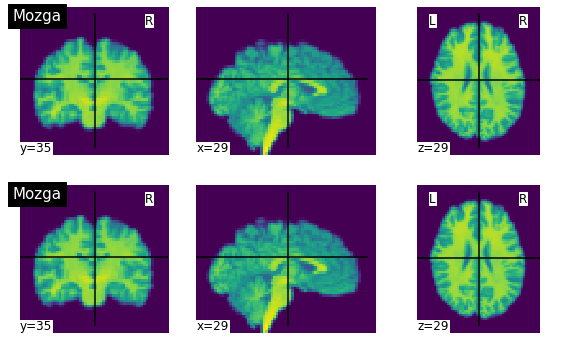

In [91]:

affine = np.diag([1, 1, 1, 1])
t = nib.Nifti1Image(tensors[0], affine)
f = plt.figure(figsize=(10,6))
ax = plt.subplot(2, 1, 1)
plotting.plot_img(t, [s/2 for s in tensors.shape[1:]], title="Mozga", axes=ax)
ax = plt.subplot(2, 1, 2)
plotting.plot_img(t, [s/2 for s in tensors.shape[1:]], title="Mozga", axes=ax)
# ax = plt.subplot(1, 4, 3)
# plotting.plot_img(t, [s/2 for s in tensors.shape[1:]], title="Mozga", axes=ax)
# ax = plt.subplot(1, 4, 4)
# plotting.plot_img(t, [s/2 for s in tensors.shape[1:]], title="Mozga", axes=ax)
# plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, y)
axs[1].plot(x, -y)

In [ ]:
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))

In [ ]:
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=16)

In [ ]:
ds[0][0].min(), ds[0][0].max()

(tensor(0.), tensor(1081.9673))

In [3]:
class AutoEncoder3d(nn.Module):
  def __init__(self, hidden_dim=256):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv3d(1, 64, kernel_size=3, padding=1), #58, 70, 58
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #29, 35, 29
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #14, 17, 14
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #7, 8, 7
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #3, 4, 3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Conv3d(64, hidden_dim, kernel_size=3, padding=1), # 3, 4, 3
        nn.AdaptiveAvgPool3d((1, 1, 1)),
        nn.Flatten()
    )

    self.decoder = nn.Sequential(
        nn.Unflatten(1, (hidden_dim, 1, 1, 1)), # 1x1x1
        nn.Upsample(size=(3, 4, 3), mode='trilinear',), #3x4x3
        nn.Conv3d(hidden_dim, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(7, 8, 7), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(14, 17, 14), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(29, 35, 29), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(58, 70, 58), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Conv3d(64, 1, kernel_size=3, padding=1)
    )
  def forward(self, X):
    x = self.encoder(X)
    return self.decoder(x)


In [4]:
model =  AutoEncoder3d()#.cuda()

In [5]:
model.load_state_dict(torch.load('MyDrive/AE_shibalda.pth',map_location=torch.device('cpu')))
model.eval;

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
crit = nn.MSELoss()

2857.043701171875


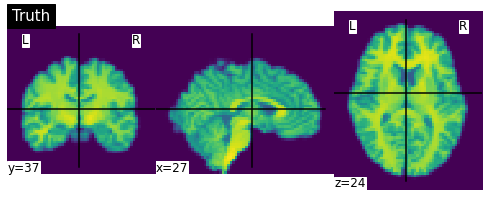

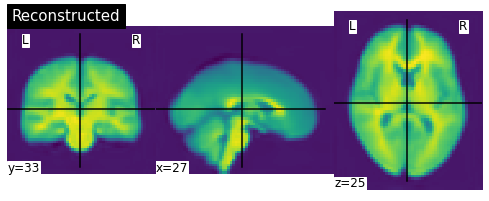

KeyboardInterrupt: ignored

In [ ]:
for e in range(10):
  for i, (X, y) in enumerate(loader):
    X = X.cuda()
    y = y.cuda()
    
    pred = model(X)
    loss = crit(pred, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%20 == 0:
      clear_output()
      print(loss.item())
      affine = np.diag([1, 1, 1, 1])
      t1 = nib.Nifti1Image(X[0][0].detach().cpu().numpy(), affine)
      t2 = nib.Nifti1Image(pred[0][0].detach().cpu().numpy(), affine)

      plotting.plot_img(t1,title="Truth")
      plotting.plot_img(t2,title="Reconstructed")
      plt.show()



In [9]:
tensors = torch.Tensor(tensors[:, None])

In [11]:
tensors.shape

torch.Size([1113, 1, 58, 70, 58])

In [13]:
latent_space = []
for i in tqdm(range(tensors.shape[0])):
  lt_space = model.encoder(tensors[i,None])
  latent_space.append(lt_space.detach().numpy().flatten())
  del lt_space
latent_space = np.array(latent_space)
# np.save("MyDrive/latent_space_vae.npy",latent_space)

In [14]:
np.save("MyDrive/latent_space_ae.npy",latent_space)

In [10]:
latent_space = np.load("MyDrive/latent_space_ae.npy")

In [6]:
import pandas as pd
labels_age = pd.read_csv('MyDrive/unrestricted_kondratevakate.csv')
labels_sex = pd.read_csv('MyDrive/unrestricted_hcp_freesurfer.csv')
labels = np.load("MyDrive/labels.npy")

In [12]:
labels_sex = pd.read_csv('MyDrive/unrestricted_hcp_freesurfer.csv')
labels_sex['Gender']

0       M
1       F
2       M
3       M
4       F
       ..
1108    M
1109    F
1110    M
1111    M
1112    F
Name: Gender, Length: 1113, dtype: object

In [13]:
labels[69]

0

In [16]:
def get_mean(line):
  a, b = line.split('-')
  return (float(a)+float(b))/2

In [17]:
age = pd.merge(labels_age, labels)
age = age['Age']

In [18]:
age[age.str.len() < 5].index

Int64Index([24, 208, 298, 359, 417, 515, 547, 557, 908, 956, 981, 1058, 1060], dtype='int64')

In [19]:
age = pd.merge(labels_age, labels)
age = age['Age']
age[age[age.str.len() < 5].index] = '36-36'
age = age.apply(get_mean)

In [131]:
latent_space.shape

(1113, 256)

In [20]:
age

0       28.0
1       28.0
2       33.0
3       28.0
4       33.0
        ... 
1108    33.0
1109    28.0
1110    28.0
1111    23.5
1112    28.0
Name: Age, Length: 1113, dtype: float64

In [40]:
age = np.array(age)

In [62]:
idx

array([391, 722, 696, ..., 554, 802, 805])

In [135]:
split = 0.7
split = int(split*age.shape[0])
idx = np.random.choice(age.shape[0], age.shape[0], replace=False).astype(int)
latent_space_train, latent_space_test = latent_space[idx[:split]], latent_space[idx[split:]]  
age_train, age_test = age[idx[:split]], age[idx[split:]]

In [141]:
labels.shape

(1113,)

In [17]:
# Разбиение пола
split = 0.7
split = int(split*labels.shape[0])
idx = np.random.choice(labels.shape[0], labels.shape[0], replace=False).astype(int)
latent_space_train, latent_space_test = latent_space[idx[:split]], latent_space[idx[split:]]  
labels_train, labels_test = labels[idx[:split]], labels[idx[split:]]

F1 Score Train: 0.9351136136469647

F1 Score Test: 0.9246573488409864



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


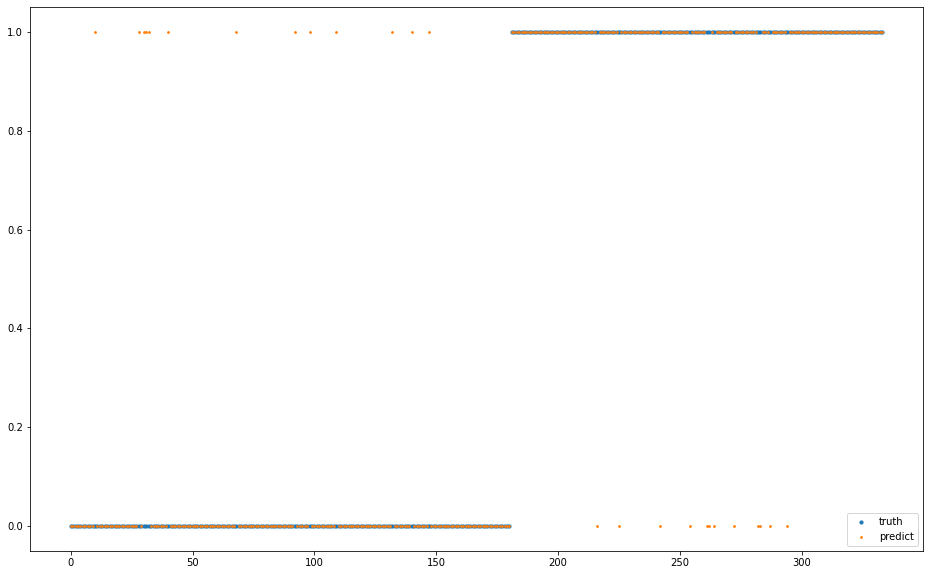

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
def rmse(model ,X,y):
  return np.sqrt(((model.predict(X)- y)**2).mean())

#Train
reg = LogisticRegression(max_iter=200).fit(latent_space_train, labels_train)
#reg_mlp = LinearRegression(,).fit(latent_space_train, age_train)
# reg_mlp.score(latent_space_train, age_train)
# rmse(reg_mlp,latent_space_train, age_train)
#print(rmse(reg_mlp,latent_space_train, age_train))
#print(reg.score(latent_space_train, labels_train))
print('F1 Score Train: {}'.format(f1_score(reg.predict(latent_space_train)[:, None], labels_train, average='macro')))
print()
# print(reg.score(latent_space_test, labels_test))
print('F1 Score Test: {}'.format(f1_score(reg.predict(latent_space_test)[:, None], labels_test, average='macro')))
print()
plt.figure(figsize=(16,10))
lim = np.arange(labels_test.shape[0])
idx = np.argsort(labels_test)
plt.scatter(lim,labels_test[idx], s=10,label='truth')
plt.scatter(lim,reg.predict(latent_space_test)[idx], s=3, label='predict')
plt.legend()

In [19]:
weights = reg.coef_

Женищна - 0
Мужчина - 1

In [20]:
weights.shape

(1, 256)

In [21]:
latent_space_woman.shape

torch.Size([1, 256])

In [22]:
latent_space_woman = latent_space[69]

In [23]:
latent_new = latent_space_woman + weights*1

In [24]:
latent_new.shape

(1, 256)

In [25]:
latent_space_woman = torch.Tensor(latent_space_woman[None,])
latent_new = torch.Tensor(latent_new)

In [26]:
latent_space_woman.shape

torch.Size([1, 256])

In [27]:
latent_new.shape

torch.Size([1, 256])

In [28]:
woman = model.decoder(latent_space_woman)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [29]:
man_rec = model.decoder(latent_new)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


TypeError: ignored

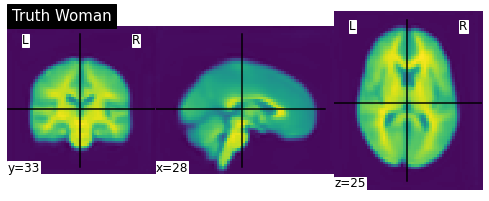

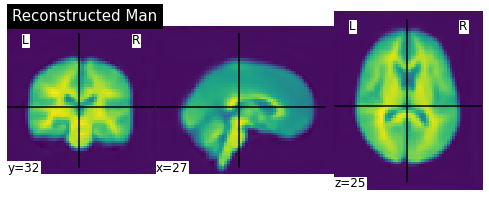

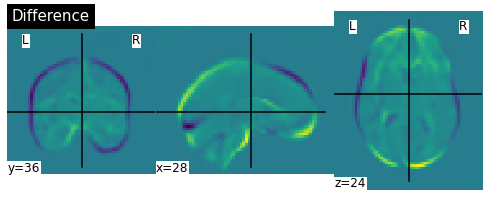

In [40]:
affine = np.diag([1, 1, 1, 1])
t1 = nib.Nifti1Image(woman[0][0].detach().numpy(), affine)
t2 = nib.Nifti1Image(man_rec[0][0].detach().numpy(), affine)
t3 = nib.Nifti1Image((woman[0][0]-man_rec[0][0]).detach().numpy(), affine)
plotting.plot_img(t1,title="Truth Woman")
plotting.plot_img(t2,title="Reconstructed Man")
plotting.plot_img(t3,title="Difference")
plt.imshow((woman[0][0]-man_rec[0][0]).detach().numpy())
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



Ineration: [1/20]  alpha: 0.000


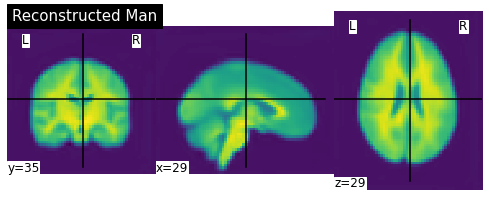


Ineration: [2/20]  alpha: 0.100


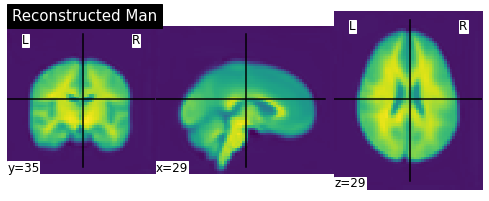


Ineration: [3/20]  alpha: 0.200


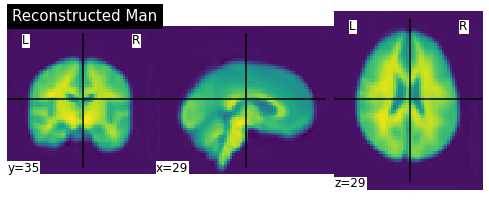

In [41]:
images = []
recs = []
# latent_space_woman = latent_space[69]
# latent_space_woman = torch.Tensor(latent_space_woman[None,])
# woman = model.decoder(latent_space_woman)
for i in range(3):
  latent_space_woman = latent_space[69]
  latent_new = latent_space_woman + weights*(80000*i)
  latent_space_woman = torch.Tensor(latent_space_woman[None,])
  latent_new = torch.Tensor(latent_new)
  woman = model.decoder(latent_space_woman)
  man_rec = model.decoder(latent_new)
  print()
  print(f'Ineration: [{i+1}/20]  alpha: {0.1*i:.3f}')
  affine = np.diag([1, 1, 1, 1])
  #t1 = nib.Nifti1Image(woman[0][0].detach().numpy(), affine)
  t2 = nib.Nifti1Image(man_rec[0][0].detach().numpy(), affine)
  images.append(t2)
  recs.append(man_rec)
  #t3 = nib.Nifti1Image((woman[0][0]-man_rec[0][0]).detach().numpy(), affine)
  # plotting.plot_img(t1,[s/2 for s in t1.shape],title="Truth Woman")
  plotting.plot_img(t2,[s/2 for s in t2.shape],title="Reconstructed Man")
  # plotting.plot_img(t3,[s/2 for s in t3.shape],title="Difference")
  plt.show()
  #del woman, man_rec

In [34]:
from PIL import Image, ImageChops
# im1 = Image.open("sample1.png")
# im2 = Image.open("sample2.png")

difference = ImageChops.difference(images[0], images[1])
# difference.save("difference.png")
plt.imshow(difference)

TypeError: ignored

In [79]:
diffs[0].shape

(1, 58, 70, 58)

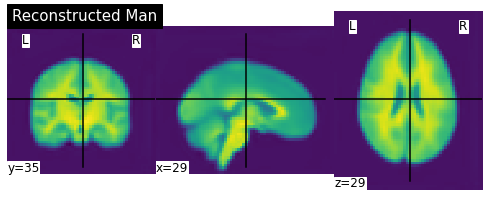

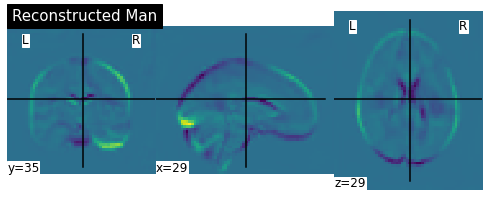

In [82]:
from IPython.display import clear_output
diffs = []
for i in range(1, len(recs)):
  diffs.append(nib.Nifti1Image(recs[i][0][0].detach().numpy() - recs[i-1][0][0].detach().numpy(), affine))
for i in range(1, len(images)):
  clear_output(True)
  plotting.plot_img(images[i-1],[s/2 for s in img.shape],title="Reconstructed Man")
  plotting.plot_img(diffs[i-1],[s/2 for s in img.shape],title="Reconstructed Man")
  plt.show()

In [ ]:
affine = np.diag([1, 1, 1, 1])
t1 = nib.Nifti1Image(X[0][0].detach().cpu().numpy(), affine)
t2 = nib.Nifti1Image(pred[0][0].detach().cpu().numpy(), affine)

plotting.plot_img(t1,title="Truth")
plotting.plot_img(t2,title="Reconstructed")
plt.show()

## Черновик, попытки классифицировать возраст

In [46]:
age_train.shape

(779,)

In [37]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(latent_space, age)
# reg.score(latent_space, age_scaled)
print(reg.score(latent_space, age))
rmse = np.sqrt((((reg.predict(latent_space))- age.values)**2).mean())
rmse

0.3013119156067492


2.9880349907377366

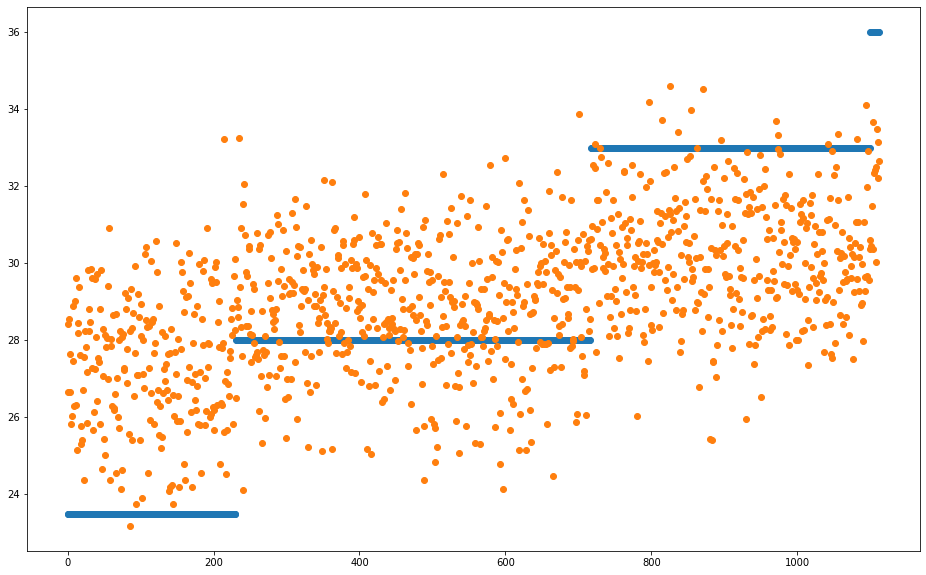

In [34]:
plt.figure(figsize=(16,10))
lim = np.arange(age.shape[0])
idx = np.argsort(age)
plt.scatter(lim,age[idx])
plt.scatter(lim,(np.sqrt(reg.predict(latent_space))[idx]))

In [93]:
from sklearn.preprocessing import OrdinalEncoder

In [98]:
enc = OrdinalEncoder()
age_cls = enc.fit_transform(age[:, None])

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5430038510911425
0.5128728155436051

0.40119760479041916
0.2659333942416921


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


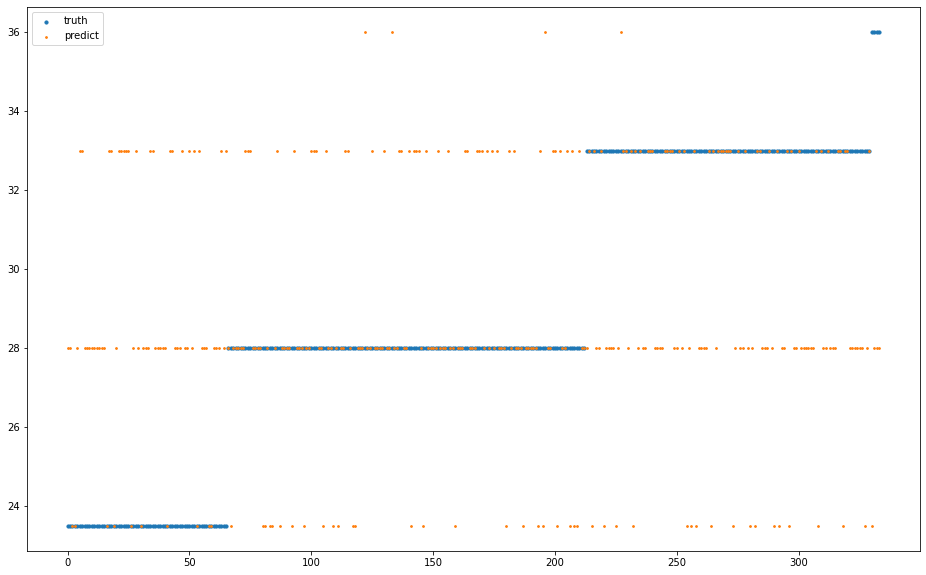

In [119]:
from sklearn.neural_network import MLPClassifier
def rmse(model ,X,y):
  return np.sqrt(((model.predict(X)- y)**2).mean())

#Train
reg_mlp = LogisticRegression(max_iter=200).fit(latent_space_train, enc.transform(age_train[:, None]))
#reg_mlp = LinearRegression(,).fit(latent_space_train, age_train)
# reg_mlp.score(latent_space_train, age_train)
# rmse(reg_mlp,latent_space_train, age_train)
#print(rmse(reg_mlp,latent_space_train, age_train))
print(reg_mlp.score(latent_space_train, enc.transform(age_train[:, None])))
print(f1_score(reg_mlp.predict(latent_space_train)[:, None], enc.transform(age_train[:, None]), average='macro'))
print()
print(reg_mlp.score(latent_space_test, enc.transform(age_test[:, None])))
print(f1_score(reg_mlp.predict(latent_space_test)[:, None], enc.transform(age_test[:, None]), average='macro'))

plt.figure(figsize=(16,10))
lim = np.arange(age_test.shape[0])
idx = np.argsort(age_test)
plt.scatter(lim,age_test[idx], s=10,label='truth')
plt.scatter(lim,(enc.inverse_transform(reg_mlp.predict(latent_space_test)[:, None])[idx]), s=3, label='predict')
plt.legend()

In [123]:
age.std()

3.574736300727006

1.0108961463076398
5.942195611584557


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


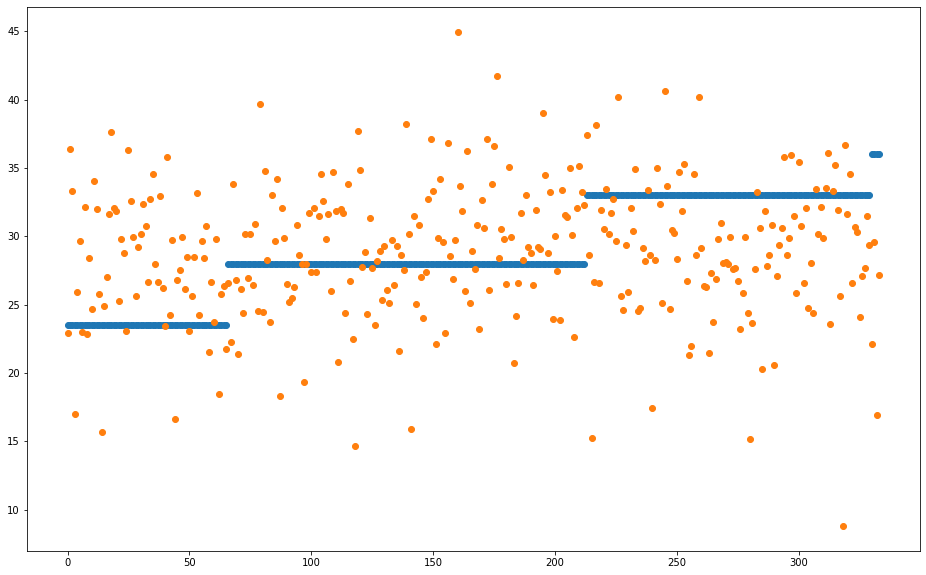

In [130]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
def rmse(model ,X,y):
  return np.sqrt(((model.predict(X)- y)**2).mean())


#Train
reg_mlp = MLPRegressor(max_iter=500, solver='lbfgs', hidden_layer_sizes=(100, 100)).fit(latent_space_train, age_train)
#reg_mlp = ElasticNet().fit(latent_space_train, age_train)
# reg_mlp.score(latent_space_train, age_train)
# rmse(reg_mlp,latent_space_train, age_train)
print(rmse(reg_mlp,latent_space_train, age_train))


#Test
print(rmse(reg_mlp,latent_space_test, age_test))

# rmse = np.sqrt(((reg_mlp.predict(latent_space_train)- age_train)**2).mean())
# rmse

plt.figure(figsize=(16,10))
lim = np.arange(age_train.shape[0])
idx = np.argsort(age_train)
plt.scatter(lim,age_train[idx])
plt.scatter(lim,(reg_mlp.predict(latent_space_train)[idx]))

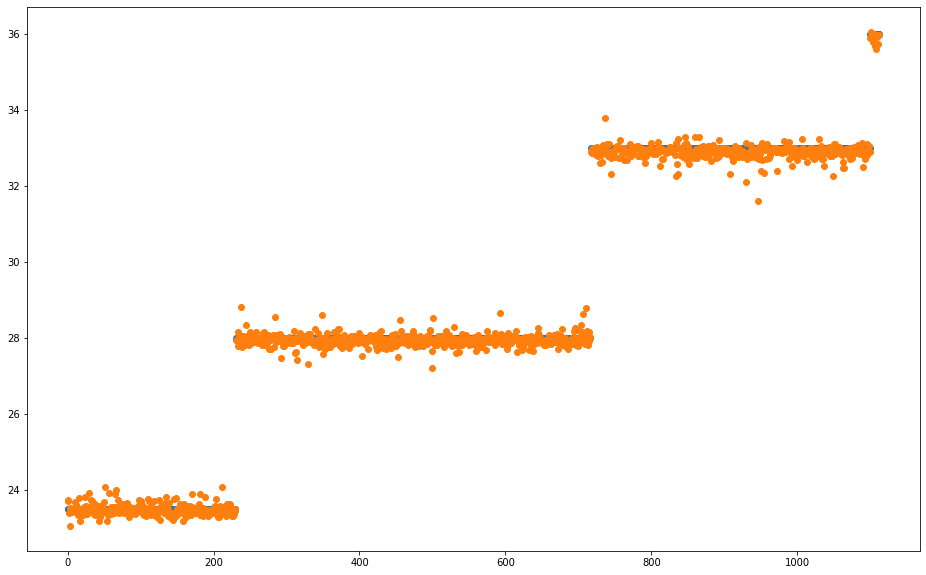

In [39]:
plt.figure(figsize=(16,10))
lim = np.arange(age.shape[0])
idx = np.argsort(age)
plt.scatter(lim,age[idx])
plt.scatter(lim,(reg_mlp.predict(latent_space)[idx]))

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
# latent_space_scaled = scaler.fit_transform(latent_space) 

In [30]:
age_scaled = scaler.fit_transform(age[:,None])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.
